# Import needed modules and useful functions

In [4]:
#-- useful python script for training the DeepTICA cvs --#
from utils import *

#-- to not visualize warnings --#
import warnings
warnings.filterwarnings('ignore')

# Simulation parameters 

In [5]:
kb=0.008314
#-- SIMULATION PARAMETERS --#
sim_parameters = {
    'temp':300, 
    'beta': 1./(300*kb),
    'kbt': None,
    #-- parameters to compute the fes --#
    'blocks':2,
    'bandwidth': 0.02,
    'plot_max_fes' :70,
}
#--------------------------------------#

# Prepare input files for plumed

In [6]:
%%time
folder = "unbias_A/bias1/bias2/bias3/"
#-- run gromacs --#
execute("./run_gromacs.sh",folder=folder)

Completed: ./run_gromacs.sh
CPU times: user 2.09 ms, sys: 12.9 ms, total: 15 ms
Wall time: 2min 17s


Text(0, 0.5, '$\\psi$')

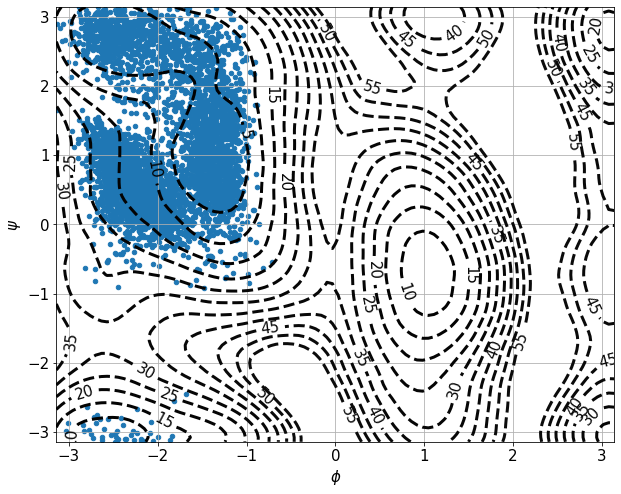

In [7]:
fig,ax = plt.subplots(1,1,figsize=(10,8))
data = load_dataframe(folder+"COLVAR")
data.plot.scatter(y="psi",x="phi",ax=ax)

fes = np.loadtxt("../../../../angles/fes.txt",delimiter=" ")
grid0 = np.loadtxt("../../../../angles/grid0.txt",delimiter=" ")
grid1 = np.loadtxt("../../../../angles/grid1.txt",delimiter=" ")
bounds = np.arange(0, 60, 5.)
c = ax.contour(grid0, grid1, fes, bounds, linewidths=3,cmap="gray",linestyles="dashed",
    norm = mpl.colors.BoundaryNorm(bounds, ncolors=len(bounds)-1, clip=False), label="FES [Kj/mol]",
)
c.clabel()
ax.grid()
ax.set_xlabel(r"$\phi$")
ax.set_ylabel(r"$\psi$")

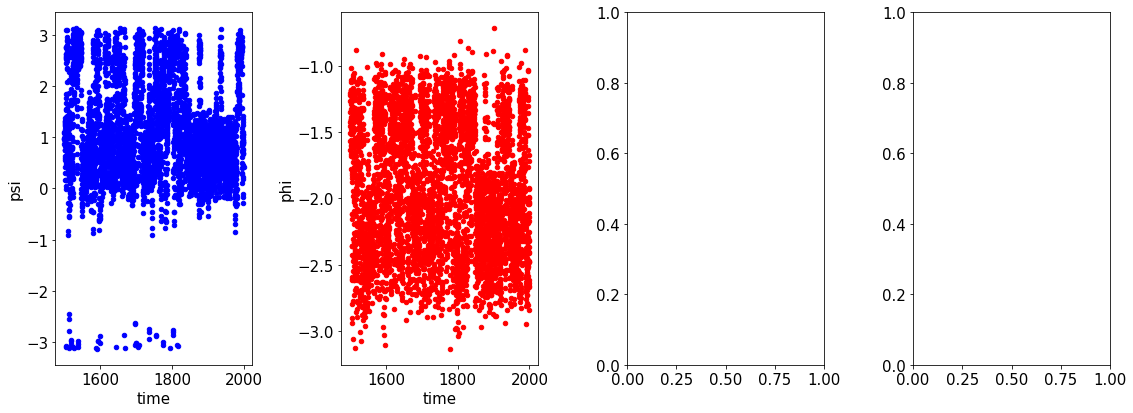

In [8]:
fig,axs = plt.subplots(1,4,figsize=(16,6))
data.plot.scatter(x="time",y="psi",ax=axs[0], color="b")
data.plot.scatter(x="time",y="phi",ax=axs[1], color="r")
#data.plot.scatter(x="time",y="omega",ax=axs[2], color="black")
#data.plot.scatter(x="time",y="theta",ax=axs[3], color="g")
plt.tight_layout()

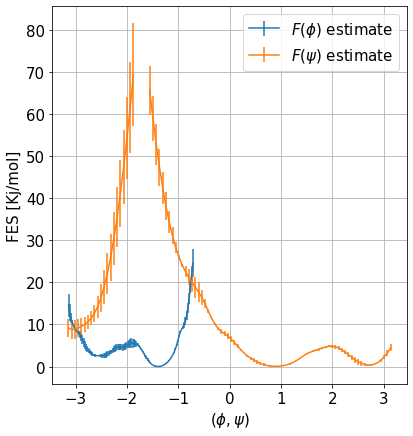

In [9]:
#-- estimation of Free Energy Surface --#
s = data.filter(regex="^p").to_numpy()
"""
logweight = data["opes.bias"].to_numpy()+data["static0.bias"].to_numpy()+data["static1.bias"].to_numpy()
logweight=( logweight-max(logweight) )#*sim_parameters["beta"]
logweight /= np.abs(min(logweight))
logweight *= sim_parameters["beta"]
"""
logweight= ( data["opes.bias"].to_numpy()-max(data["opes.bias"].to_numpy()) )*sim_parameters["beta"]

fig, ax = plt.subplots(figsize=(6,6))
for i in range(2):
    fes,grid,bounds,error = compute_fes(s[:,i], weights=np.exp(logweight),
                                        temp=sim_parameters["temp"],
                                        kbt=sim_parameters["kbt"],
                                        blocks=sim_parameters["blocks"],
                                        bandwidth=sim_parameters["bandwidth"],scale_by='range',
                                        plot=True, plot_max_fes=sim_parameters["plot_max_fes"], ax = ax)
ax.legend([r"$F(\phi)$ estimate",r"$F(\psi)$ estimate"])   
ax.grid()
plt.tight_layout()
ax.set_xlabel(r"$(\phi,\psi)$")
ax.set_ylabel("FES [Kj/mol]")

plt.show()

<AxesSubplot:xlabel='time', ylabel='xx2'>

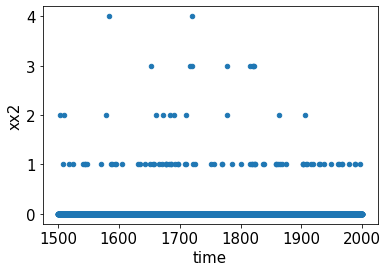

In [10]:
data.plot.scatter(y="xx2",x="time")

<AxesSubplot:xlabel='time', ylabel='opes.bias'>

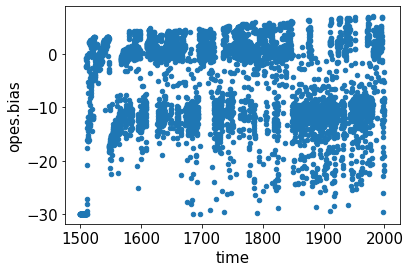

In [11]:
data.plot.scatter(y="opes.bias",x="time")

In [12]:
data = load_dataframe(folder+"COLVAR")
descriptors_names = data.filter(regex='^d[^a-z]').columns.values

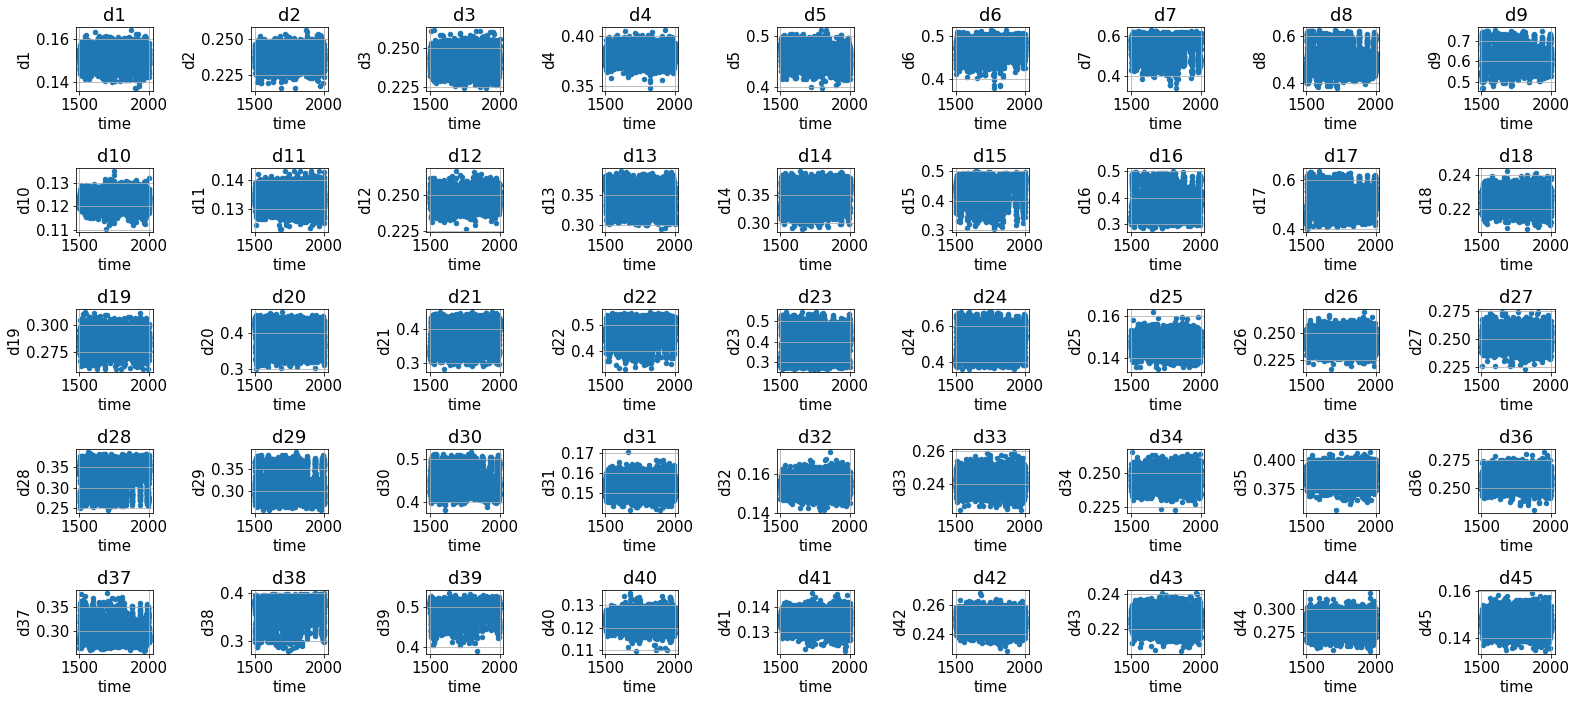

In [13]:
fig,axs = plt.subplots(5,9,figsize=(22,10))#,sharey=True)

for ax,desc in zip(axs.flatten(),descriptors_names):
    data.plot.scatter(x="time",y=desc,alpha=1,ax=ax,legend=False,grid=True)#,density=True)
    ax.set_title(desc)

plt.tight_layout()

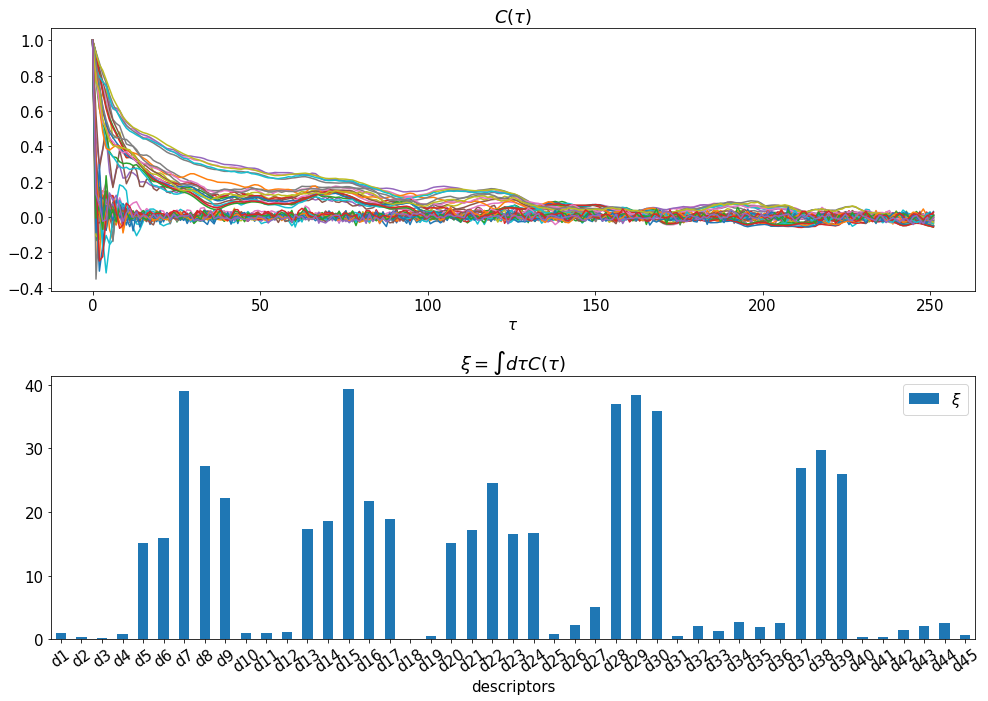

39.375116085762336
0.08869004342088257


In [14]:
fig,axs = plt.subplots(2,1,figsize=(14,10))#,sharey=True)
data = data[:]
#-- in ps --#
last=250
x = np.linspace(0,last+1,last)
acorr = np.empty(last)
timescale = np.empty(len(descriptors_names))
k=0
for desc in descriptors_names:
    #print("autocorrelation for ", desc)
    for i in range(last):
        acorr[i] = data[desc].autocorr(i)
    axs[0].plot(x,acorr)
    timescale[k] = integrate.trapz(acorr[:last],x[:last])
    k+=1

times = pd.DataFrame(descriptors_names,columns=["descriptors"])
times["timescale"] = timescale
times.plot(kind="bar",x="descriptors",y="timescale",rot=35,ax=axs[1],fontsize=15,label=r"$\xi$")

axs[0].set_xlabel(r'$\tau$')
axs[0].set_title(r'$C(\tau)$')
axs[1].set_title(r'$\xi=\int d\tau C(\tau)$')

plt.tight_layout()
plt.show()

print(np.max(timescale))
print(np.min(timescale))

#without integrating, but fitting
#fit_timeacorr(descriptors_names,data,axs=None)

In [15]:
descriptors = times[ times['timescale']>0 ]["descriptors"].tolist()
#descriptors.append("ene")
n_input = len(descriptors)
print(descriptors)
data[descriptors]

['d1', 'd2', 'd3', 'd4', 'd5', 'd6', 'd7', 'd8', 'd9', 'd10', 'd11', 'd12', 'd13', 'd14', 'd15', 'd16', 'd17', 'd18', 'd19', 'd20', 'd21', 'd22', 'd23', 'd24', 'd25', 'd26', 'd27', 'd28', 'd29', 'd30', 'd31', 'd32', 'd33', 'd34', 'd35', 'd36', 'd37', 'd38', 'd39', 'd40', 'd41', 'd42', 'd43', 'd44', 'd45']


,d1,d2,d3,d4,d5,d6,d7,d8,d9,d10,...,d36,d37,d38,d39,d40,d41,d42,d43,d44,d45
0,0.155404,0.235609,0.245913,0.385077,0.485555,0.452589,0.552779,0.437989,0.548319,0.119131,...,0.248879,0.263899,0.376640,0.503408,0.124357,0.136036,0.255202,0.227047,0.291071,0.148732
1,0.153824,0.236336,0.239697,0.380680,0.482927,0.442907,0.545023,0.431778,0.535411,0.122198,...,0.248677,0.273952,0.372118,0.502487,0.121456,0.136670,0.254765,0.225718,0.292587,0.145788
2,0.152914,0.230950,0.245917,0.387303,0.478927,0.470290,0.575404,0.456090,0.578510,0.119899,...,0.254026,0.280875,0.372947,0.498609,0.125501,0.132561,0.244679,0.227214,0.280082,0.147729
3,0.153964,0.241614,0.240954,0.381560,0.479436,0.474449,0.580484,0.476103,0.603944,0.124190,...,0.258861,0.280877,0.384614,0.504388,0.124218,0.134896,0.246102,0.223586,0.275135,0.145131
4,0.151751,0.235886,0.241760,0.380900,0.482345,0.445046,0.553208,0.432821,0.531998,0.121437,...,0.253916,0.279792,0.373575,0.500484,0.122243,0.131383,0.246628,0.219652,0.280518,0.144723
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4996,0.148485,0.233332,0.233897,0.376723,0.429970,0.484678,0.569282,0.526068,0.662836,0.123799,...,0.266779,0.287389,0.396167,0.517495,0.128884,0.137647,0.251844,0.229490,0.283790,0.147484
4997,0.154695,0.243244,0.251205,0.389976,0.463198,0.494466,0.601219,0.502147,0.625256,0.127482,...,0.262026,0.284963,0.387033,0.506971,0.124714,0.134749,0.248102,0.221417,0.275256,0.144466
4998,0.142213,0.229489,0.237330,0.383662,0.464403,0.488580,0.609911,0.470656,0.586678,0.120361,...,0.259243,0.292679,0.371656,0.504825,0.127349,0.129874,0.247700,0.227816,0.294216,0.143803
4999,0.155108,0.231663,0.255972,0.393204,0.460569,0.505643,0.614610,0.499315,0.619065,0.120522,...,0.260341,0.285584,0.369013,0.497382,0.120611,0.127470,0.247801,0.215128,0.282741,0.145287


# Training Deep-TICA
## Parameters

In [16]:
data = load_dataframe(folder+"COLVAR")
#-- TRAINING PARAMETERS --#
n_output = 2 # 2 non linear combination of the descriptors  
n_input = 45
train_parameters = {
              'descriptors': descriptors, 
              'nodes':[n_input,30,30,n_output], # [n_input,10,10,n_output] va bene
              'activ_type': 'tanh',#'relu','selu','tanh'
              'lag_time':10, 
              'loss_type': 'sum', 
              'n_eig': n_output,
              'trainsize':0.75, 
              'lrate':1e-3,
              'l2_reg':0.,
              'num_epochs':500,
              'batchsize': -1, #---> è da fare sul train loder and valid loader
              'es_patience':10,
              'es_consecutive':True,
              'standardize_outputs':False,
              'standardize_inputs': True,
              'log_every':50,
              }
#--------------------------------------#

### DeepTICA loading data

In [17]:
from mlcvs.utils.data import find_time_lagged_configurations

def create_time_lagged_dataset(X, t = None, lag_time = 10, logweights = None, tprime = None, interval = None):
    """
    Create a dataset of time-lagged configurations. If a set of (log)weights is given the search is performed in the accelerated time.

    Parameters
    ----------
    X : array-like
        input descriptors
    t : array-like, optional
        time series, by default np.arange(len(X))
    lag_time: float, optional
        lag between configurations, by default = 10        
    logweights : array-like,optional
        logweights to evaluate rescaled time as dt' = dt*exp(logweights)
    tprime : array-like,optional
        rescaled time estimated from the simulation. If not given 'tprime_evaluation(t,logweights)' is used instead
    """

    # check if dataframe
    if type(X) == pd.core.frame.DataFrame:
        X = X.values
    if type(t) == pd.core.frame.DataFrame:
        t = t.values

    # assert
    assert t.ndim == 1 
    assert len(X) == len(t)

    # define time if not given
    if t is None:
        t = np.arange(0,len(X))

    #define tprime if not given
    if tprime is None:
        tprime = tprime_evaluation(t, logweights)

    # find pairs of configurations separated by lag_time
    data = find_time_lagged_configurations(X, tprime,lag=lag_time)
    
    if interval is not None:
        # covert to a list
        data = list(data)
        # assert dimension of interval
        assert len(interval) == 2
        # modifies the content of data by slicing
        for i in range(len(data)):
            data[i] = data[i][interval[0]:interval[1]]

    #return data
    return torch.utils.data.TensorDataset(*data)

### DeepTICA loading data

In [18]:
torch.manual_seed(21)
skip = 0
min_lag,max_lag = 0.1,1.9
#print( np.exp(-min_lag*sim_parameters["beta"]*0.5), max_lag*np.exp(-sim_parameters["beta"]*0.5) )
#min_lag,max_lag = min_lag*np.exp(-sim_parameters["beta"]*0.5), max_lag*np.exp(-sim_parameters["beta"]*0.5)
lags = np.linspace(min_lag,max_lag,5)
#names = data[descriptors].columns.values
train_datasets = []
valid_datasets = []

n_train = int( len(data)*train_parameters["trainsize"] )
n_valid = int( len(data)*(1-train_parameters["trainsize"])-int(10*max_lag) )

In [19]:
#-- unbias simulation --#
data = load_dataframe("unbias_A/COLVAR")
data = data[skip:]
# descriptors
X = data[descriptors].values 
n_features = X.shape[1]
# time
t = data['time'].values
# tprime and logweights
tprime = None
logweight = None

# create time lagged dataset with different lag times
for lag in lags:
    #random split
    # TensorDataset (x_t,x_lag,w_t,w_lag)
    print("lag: ", np.round(lag,3))
    dataset = create_time_lagged_dataset(X,t=t,lag_time=np.round(lag,3),logweights=logweight,tprime=tprime,interval=[0,n_train+n_valid])
    print("---------------------------------------")
    train_data, valid_data = random_split(dataset,[n_train,n_valid])
    train_datasets.append(train_data)
    valid_datasets.append(valid_data)

lag:  0.1
---------------------------------------
lag:  0.55
---------------------------------------
lag:  1.0
---------------------------------------
lag:  1.45
---------------------------------------
lag:  1.9
---------------------------------------


In [20]:
#--- bias simulations --#
List = ["unbias_A/bias1/COLVAR","unbias_A/bias1/bias2/COLVAR",folder+"COLVAR"]
for set in List:
    data = load_dataframe(set)
    data = data[skip:]
    # descriptors
    X = data[descriptors].values 
    n_features = X.shape[1]
    # time
    t = data['time'].values

    # alternative method to not modify temperature but only rescale the bias
    logweight = data["opes.bias"].to_numpy()-max(data["opes.bias"].to_numpy())
    #logweight = data["opes.bias"].to_numpy()
    logweight /= np.abs(min(logweight))
    logweight *= sim_parameters["beta"]
    dt = t[1]-t[0]
    tprime = dt * np.cumsum(np.exp(logweight))

    # create time lagged dataset with different lag times
    for lag in lags:
        #random split
        # TensorDataset (x_t,x_lag,w_t,w_lag)
        print("lag: ", np.round(lag,3))
        dataset = create_time_lagged_dataset(X,t=t,lag_time=np.round(lag,3),logweights=logweight,tprime=tprime,interval=[0,n_train+n_valid])
        print("---------------------------------------")
        train_data, valid_data = random_split(dataset,[n_train,n_valid])
        train_datasets.append(train_data)
        valid_datasets.append(valid_data)

lag:  0.1
---------------------------------------
lag:  0.55
---------------------------------------
lag:  1.0
---------------------------------------
lag:  1.45
---------------------------------------
lag:  1.9
---------------------------------------
lag:  0.1
---------------------------------------
lag:  0.55
---------------------------------------
lag:  1.0
---------------------------------------
lag:  1.45
---------------------------------------
lag:  1.9
---------------------------------------
lag:  0.1
---------------------------------------
lag:  0.55
---------------------------------------
lag:  1.0
---------------------------------------
lag:  1.45
---------------------------------------
lag:  1.9
---------------------------------------


In [21]:
train_loader = FastTensorDataLoader(train_datasets, batch_size=n_train)
valid_loader = FastTensorDataLoader(valid_datasets, batch_size=n_valid)

### Setting training features and regularizations

In [22]:
# DEVICE
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# MODEL
model = DeepTICA_CV(train_parameters['nodes'],activation=train_parameters['activ_type'],gaussian_random_initialization=True)
'''
# load checkpoint previous simulation
model.load_checkpoint("unbias_A/bias1/bias2/deeptica/model_checkpoint.pt")
model.epochs = 0
model.loss_train = []
model.loss_valid = []
model.evals_train = []
#model.tica.symmetrize = False
'''
model.to(device)

# OPTIMIZER (Adam)
opt = torch.optim.Adam(model.parameters(), lr=train_parameters['lrate'], weight_decay=train_parameters['l2_reg'])
# lrscheduler
#model.set_LRScheduler(opt,min_lr=5e-5)
model.set_optimizer(opt)

if valid_loader is not None:
    # EarlyStopping
    model.set_earlystopping(patience=train_parameters['es_patience'],
                            min_delta=0.005,consecutive=train_parameters['es_consecutive'], save_best_model=True, log=False)

### DeepTICA fit

In [23]:
# TRAIN
model.fit(train_loader=train_loader,valid_loader=valid_loader,
    standardize_inputs=train_parameters['standardize_inputs'],
    standardize_outputs=train_parameters['standardize_outputs'],
    loss_type=train_parameters['loss_type'],
    n_eig=train_parameters['n_eig'],
    nepochs=train_parameters['num_epochs'],
    info=False, log_every=train_parameters['log_every'])

Epoch Train Loss  Valid Loss  Eigenvalues             
50    -1.319      -1.302      0.431  0.149  
100   -1.399      -1.381      0.463  0.156  
150   -1.432      -1.413      0.476  0.163  
INFO: Early stopping
151   -1.432      -1.414      0.476  0.163  


In [24]:
#-- move the model back to cpu for convenience --#
model.to('cpu')

#-- export checkpoint (for loading the model back to python) and torchscript traced module --#
save_folder = folder+"deeptica/"
try:
    os.mkdir(save_folder)
except:
    print("already exists")
#-- move to cpu before saving results --#
model.to("cpu")
model.export(save_folder)
print("model saved")

#-- print some useful results --#
print("timescales: ",model.tica.timescales(train_parameters["lag_time"]).detach().cpu().numpy()) 
print("eigenvalues: ",model.tica.evals_.detach().cpu().numpy())
print("gap: ", model.tica.evals_.detach().cpu().numpy()[0]-model.tica.evals_.detach().cpu().numpy()[1])

model saved
timescales:  [13.4731     5.5138183]
eigenvalues:  [0.47605604 0.1630619 ]
gap:  0.31299412


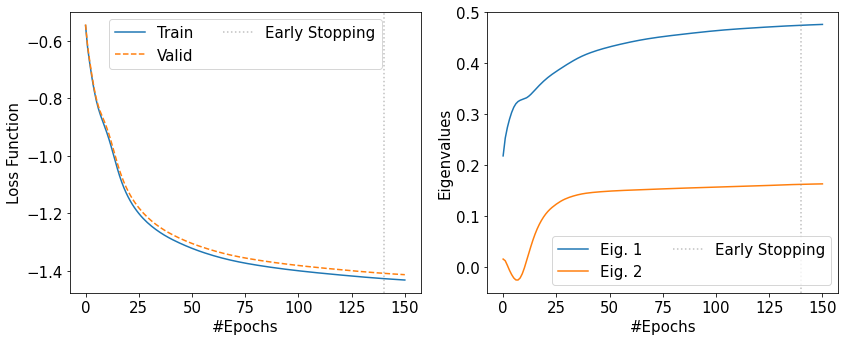

In [25]:
plot_model_lossfunction(model)

#### Adding to data the cvs values

In [26]:
descriptors_names = data.filter(regex='^d[^a-z]').columns.values
data_complete = load_dataframe("../../../../angles/COLVAR")
X_complete = data_complete[descriptors_names].to_numpy()
logweight= ( data["opes.bias"].to_numpy()-max(data["opes.bias"].to_numpy()) )*sim_parameters["beta"]

In [27]:
data["cv1"] = np.transpose(model(torch.Tensor(X)).detach().cpu().numpy())[0]
data["cv2"] = np.transpose(model(torch.Tensor(X)).detach().cpu().numpy())[1]
data_complete["cv1"] = np.transpose(model(torch.Tensor(X_complete)).detach().cpu().numpy())[0]
data_complete["cv2"] = np.transpose(model(torch.Tensor(X_complete)).detach().cpu().numpy())[1]

<AxesSubplot:ylabel='Frequency'>

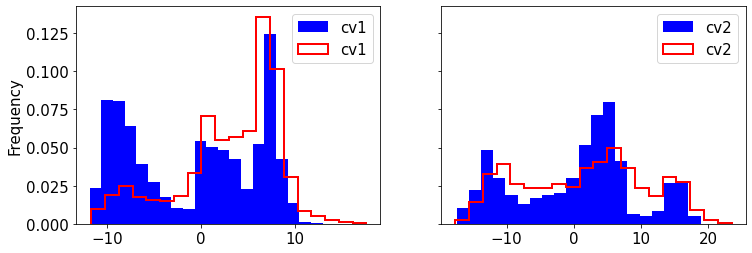

In [28]:
fig,axs = plt.subplots(1,2,figsize=(12,4),sharey=True)
data.plot.hist(y="cv1",bins=20,ax=axs[0],density=True,color="b")
data.plot.hist(y="cv2",bins=20,ax=axs[1],density=True,color="b")
data_complete.plot.hist(y="cv1",bins=20,ax=axs[0],density=True,color="r",histtype='step',linewidth=2)
data_complete.plot.hist(y="cv2",bins=20,ax=axs[1],density=True,color="r",histtype='step',linewidth=2)

## Power Spectral density

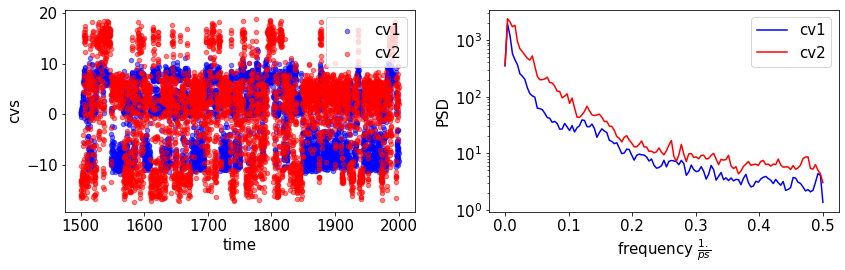

In [29]:
## time series
c = ["b","r"]
fig,axs = plt.subplots(1,2,figsize=(12,4))
for j,color in enumerate(c):
    data.plot.scatter(y="cv"+str(j+1),x="time",ax=axs[0],color=color,label="cv"+str(j+1),alpha=0.5)
axs[0].set_ylabel("cvs")    
axs[0].legend()

## PSD
T = 1 # valued saved each ps
fs = 1/T # frequency 
for j,color in enumerate(c):
    f, Pxx = signal.welch(data["cv"+str(j+1)].to_numpy()[:], fs)
    #axs[1].plot(f, Pxx, color=color,label="cv"+str(j))
    axs[1].semilogy(f,Pxx, color=color,label="cv"+str(j+1)); #axs[1].semilogx()
axs[1].set_xlabel(r"frequency $\frac{1.}{ps}$")
axs[1].set_ylabel(r"PSD")
axs[1].legend()
plt.tight_layout()

We can also plot the correlation (*Pearson* correlation ,which simply means normed correlation) of the Deep-TICA cvs with the descriptors

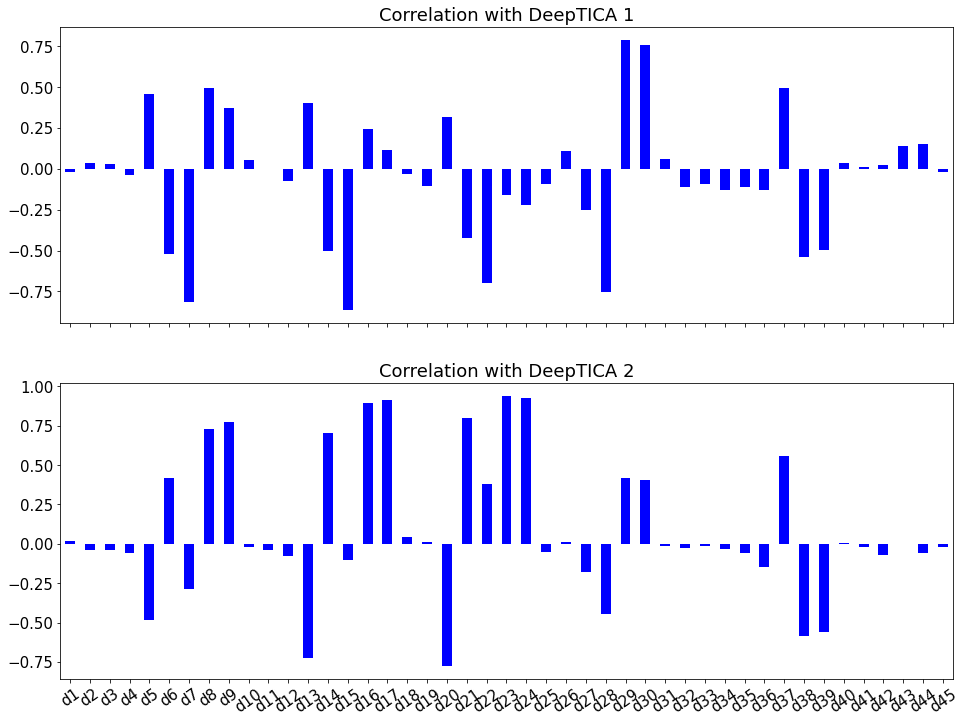

In [30]:
fig,axs = plt.subplots(2,1,figsize=(16,12),sharex=True)
for k,cv in enumerate(["cv1","cv2"]):
    cols = [cv]
    cols.extend(data[descriptors].columns)
    corr = data[cols].corr(method='pearson')
    corr[cv].drop(cv).plot(kind='bar', ax=axs[k], rot=35, color="b",label=r"$C(deep|desc)$")
    axs[k].set_title('Correlation with DeepTICA '+str(k+1))
plt.show()

### FES estimate from cvs  
Obviously from this first simulation it is not possible to found a cvs that from data are able to distinguish all the possible basins. I recall that our approach is a **data drive approach**.  


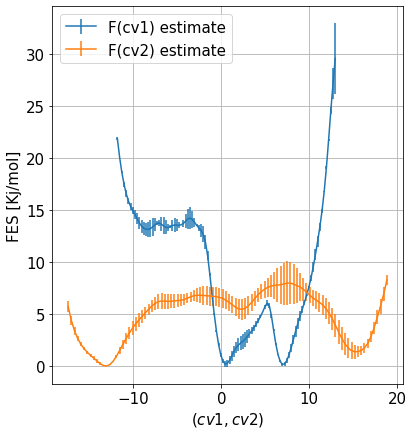

In [31]:
#-- estimation of Free Energy Surface --#
s = data.filter(regex="^cv").to_numpy()
cvs_fes = []
fig, ax = plt.subplots(figsize=(6,6))
for i in range(2):
    fes,grid,bounds,error = compute_fes(s[:,i], weights=np.exp(logweight),
                                        temp=sim_parameters["temp"],
                                        kbt=sim_parameters["kbt"],
                                        blocks=sim_parameters["blocks"],
                                        bandwidth=sim_parameters["bandwidth"],scale_by='range',
                                        plot=True, plot_max_fes=sim_parameters["plot_max_fes"], ax = ax)
    cvs_fes.append(fes)
ax.legend(["F(cv1) estimate","F(cv2) estimate"])   
ax.grid()
plt.tight_layout()
ax.set_xlabel(r"$(cv1,cv2)$")
ax.set_ylabel("FES [Kj/mol]")

plt.show()

In [32]:
# entropy from fes
import scipy 

counts = np.exp(-sim_parameters["beta"]*cvs_fes[0])
entropy = scipy.stats.entropy(counts)
print("Entropy cv2 ",entropy)

counts = np.exp(-sim_parameters["beta"]*cvs_fes[1])
entropy = scipy.stats.entropy(counts)
print("Entropy cv2 ",entropy)

Entropy cv2  3.6251191560262863
Entropy cv2  4.036590153143786


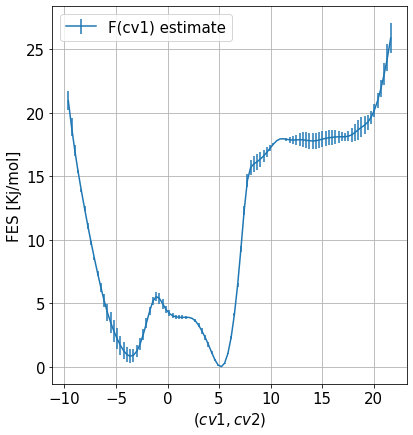

0.6695995245224716
0.5978364856211518


In [33]:
# jensenshannon distance between two probability
from scipy.spatial import distance

s = data["deep2.node-0"].to_numpy()
fig, ax = plt.subplots(figsize=(6,6))
fes,grid,bounds,error = compute_fes(s, weights=np.exp(logweight),
                                    temp=sim_parameters["temp"],
                                    kbt=sim_parameters["kbt"],
                                    blocks=sim_parameters["blocks"],
                                    bandwidth=sim_parameters["bandwidth"],scale_by='range',
                                    plot=True, plot_max_fes=sim_parameters["plot_max_fes"], ax = ax)
ax.legend(["F(cv1) estimate","F(cv2) estimate"])   
ax.grid()
plt.tight_layout()
ax.set_xlabel(r"$(cv1,cv2)$")
ax.set_ylabel("FES [Kj/mol]")

plt.show()

# se < di 0.5 allora tengo solo quella nuova
# se > 0.5 significa che danno informazioni diverse, per cui tengo entrambe
print(distance.jensenshannon( np.exp(-sim_parameters["beta"]*cvs_fes[0]) , np.exp(-sim_parameters["beta"]*fes) ))

# se < di 0.5 allora tengo solo quella nuova
# se > 0.5 significa che danno informazioni diverse, per cui tengo entrambe
print(distance.jensenshannon( np.exp(-sim_parameters["beta"]*cvs_fes[1]) , np.exp(-sim_parameters["beta"]*fes) ))

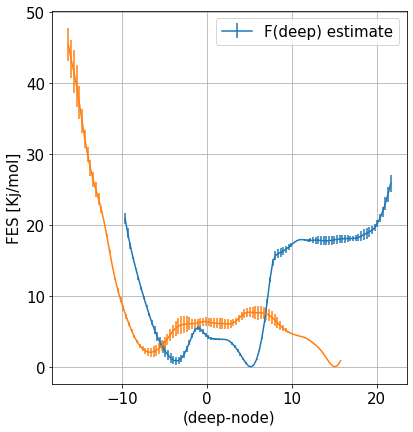

In [34]:
#-- estimation of Free Energy Surface, with new cv --#
s = data.filter(regex="deep2.node").to_numpy()

fig, ax = plt.subplots(figsize=(6,6))
for i in range(2):
    fes,grid,bounds,error = compute_fes(s[:,i], weights=np.exp(logweight),
                                            temp=sim_parameters["temp"],
                                            kbt=sim_parameters["kbt"],
                                            blocks=sim_parameters["blocks"],
                                            bandwidth=sim_parameters["bandwidth"],scale_by='range',
                                            plot=True, plot_max_fes=sim_parameters["plot_max_fes"], ax = ax)
ax.legend(["F(deep) estimate"])   
ax.grid()
plt.tight_layout()
ax.set_xlabel("(deep-node)")
ax.set_ylabel("FES [Kj/mol]")

plt.show()

### Isolines  
We can use the data obtained from **angles** folder, biasing both $\psi$ and $\phi$ angles, to plot the isolines of the new Cvs   

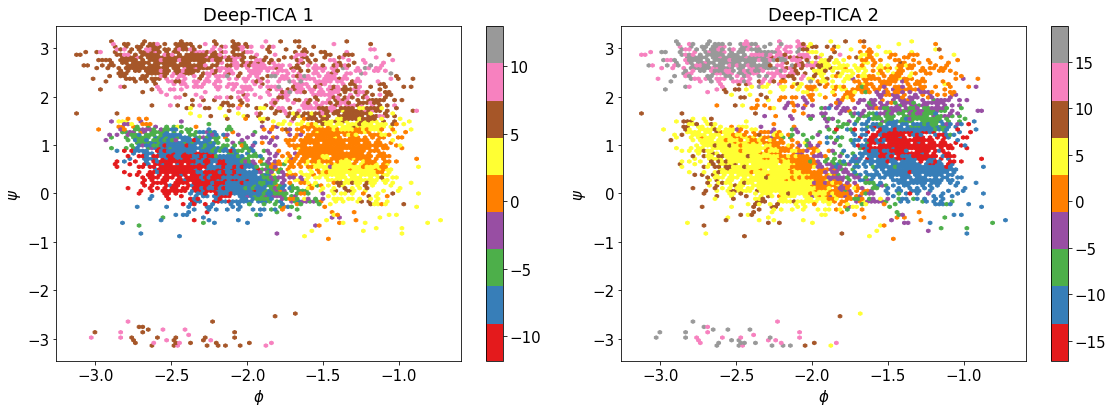

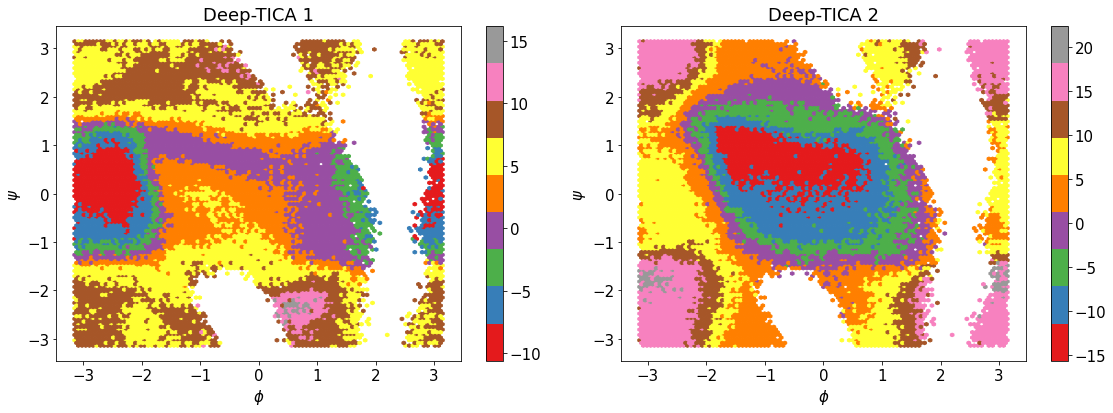

In [35]:
fig,axs = plt.subplots(1,2,figsize=(16,6))
for k,ax in enumerate(axs):
    data.plot.hexbin(y="psi",x="phi",C="cv"+str(k+1),cmap="Set1",ax=ax)
    ax.set_xlabel(r"$\phi$")
    ax.set_ylabel(r"$\psi$")
    ax.set_title('Deep-TICA '+str(k+1))
plt.tight_layout()
fig,axs = plt.subplots(1,2,figsize=(16,6))
for k,ax in enumerate(axs):
    data_complete.plot.hexbin(y="psi",x="phi",C="cv"+str(k+1),cmap="Set1",ax=ax)
    ax.set_xlabel(r"$\phi$")
    ax.set_ylabel(r"$\psi$")
    ax.set_title('Deep-TICA '+str(k+1))
plt.tight_layout()

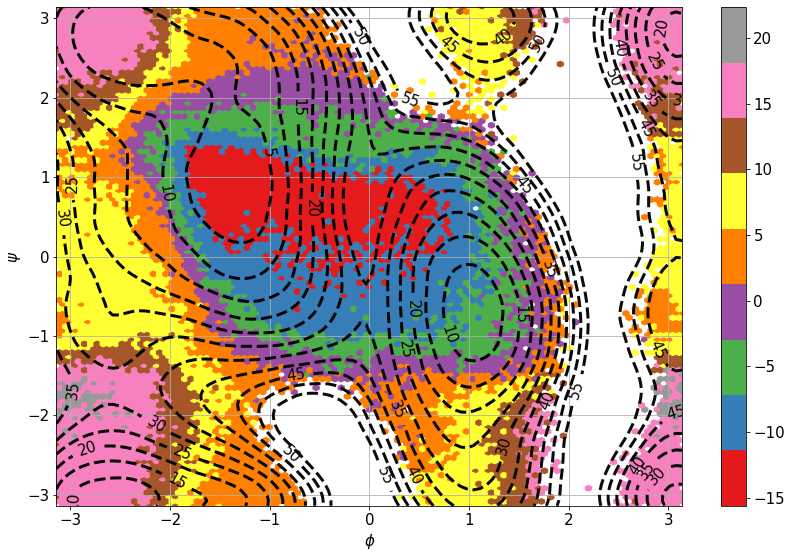

In [36]:
fig,ax = plt.subplots(1,1,figsize=(12,8))
data_complete.plot.hexbin(y="psi",x="phi",C="cv2",cmap="Set1",ax=ax)

fes = np.loadtxt("../../../../angles/fes.txt",delimiter=" ")
grid0 = np.loadtxt("../../../../angles/grid0.txt",delimiter=" ")
grid1 = np.loadtxt("../../../../angles/grid1.txt",delimiter=" ")
bounds = np.arange(0, 60, 5.)
c = ax.contour(grid0, grid1, fes, bounds, linewidths=3,cmap="gray",linestyles="dashed",
    norm = mpl.colors.BoundaryNorm(bounds, ncolors=len(bounds)-1, clip=False), label="FES [Kj/mol]",
)
c.clabel()
ax.grid()
ax.set_xlabel(r"$\phi$")
ax.set_ylabel(r"$\psi$")

plt.tight_layout()

### Orthogonality  
We said that the **ICs** must satisfy two conditions. The first one is that they are uncorrelated, which means that $\int d \vec x \psi_1(\vec x) \psi_2(\vec x) e^{-\beta U(\vec x)} = 0$.  
But their scalar product on the data will lead to a slightly different result, in this case approximately $0$, but not perfectly $0$

In [37]:
Boltzmann_product(model,model,X,j=0,k=1)

-4.582007570919738

This results reflects the fact that we have enforce the symmetrization of $C(\tau)$  
then one can enforce the orthogonality on the data

In [38]:
#-- check scalar product --#
#DeepTICA 1
cv1 = np.transpose(model(torch.Tensor(X)).detach().cpu().numpy())[0]
#DeepTICA 2 orthogonal to DeepTICA 1
new_cv2 = orthogonal_cv(model,X)
prod = np.multiply(np.multiply(cv1,np.ones(X.shape[0])),new_cv2).mean()
print(prod)

-1.682444232392918e-07


Text(0.5, 1.0, 'Deep-TICA 2 orthogonal')

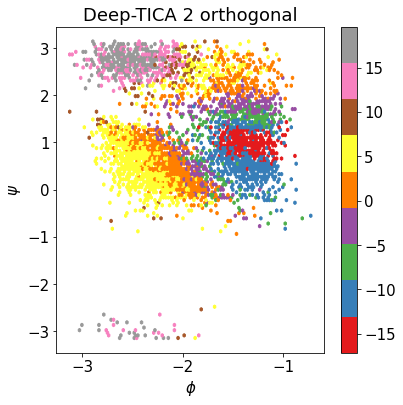

In [39]:
data["cv2_orthogonal"] = new_cv2
fig,ax = plt.subplots(1,1,figsize=(6,6))
data.plot.hexbin(y="psi",x="phi",C="cv2_orthogonal",cmap="Set1",ax=ax)
ax.set_xlabel(r"$\phi$")
ax.set_ylabel(r"$\psi$")
ax.set_title('Deep-TICA 2 orthogonal')

# Prepare the next simulation input files
### Plumed

## First possibility : excluded region

In [40]:
## excluded region
data = load_dataframe(folder+"COLVAR")
descriptors_names = data.filter(regex='^d[^a-z]').columns.values
excluded_region = "xx3: CUSTOM ...\n\tPERIODIC=NO\n\tARG="
for desc in descriptors_names:
    excluded_region += desc
    if desc is not descriptors_names[-1]:
        excluded_region += ","
excluded_region += "\n\tVAR="

for i in range(len(descriptors_names)):
    var = "x"+str(i)
    excluded_region += var
    if i is not len(descriptors_names)-1:
        excluded_region += ","

excluded_region += "\n\tFUNC="

for i,desc in enumerate(descriptors_names):
    func = "step((x"+str(i)+"-"+str(np.round(min(data[desc]),3))+")*(x"+str(i)+"-"+str(np.round(max(data[desc]),3))+"))"
    excluded_region += func
    if desc is not descriptors_names[-1]:
        excluded_region += "+" 

excluded_region += "\n..."

print(excluded_region)

xx3: CUSTOM ...
	PERIODIC=NO
	ARG=d1,d2,d3,d4,d5,d6,d7,d8,d9,d10,d11,d12,d13,d14,d15,d16,d17,d18,d19,d20,d21,d22,d23,d24,d25,d26,d27,d28,d29,d30,d31,d32,d33,d34,d35,d36,d37,d38,d39,d40,d41,d42,d43,d44,d45
	VAR=x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23,x24,x25,x26,x27,x28,x29,x30,x31,x32,x33,x34,x35,x36,x37,x38,x39,x40,x41,x42,x43,x44
	FUNC=step((x0-0.137)*(x0-0.164))+step((x1-0.216)*(x1-0.256))+step((x2-0.224)*(x2-0.262))+step((x3-0.348)*(x3-0.406))+step((x4-0.397)*(x4-0.512))+step((x5-0.38)*(x5-0.514))+step((x6-0.342)*(x6-0.628))+step((x7-0.379)*(x7-0.625))+step((x8-0.47)*(x8-0.755))+step((x9-0.111)*(x9-0.135))+step((x10-0.123)*(x10-0.143))+step((x11-0.227)*(x11-0.267))+step((x12-0.295)*(x12-0.389))+step((x13-0.29)*(x13-0.392))+step((x14-0.306)*(x14-0.501))+step((x15-0.284)*(x15-0.502))+step((x16-0.402)*(x16-0.64))+step((x17-0.209)*(x17-0.242))+step((x18-0.259)*(x18-0.312))+step((x19-0.3)*(x19-0.457))+step((x20-0.281)*(x20-0.45))+step((x21-0

In [41]:
folder = "unbias_A/bias1/bias2/bias3/bias4/"
Path(folder).mkdir(parents=True, exist_ok=True)

with open(folder+"plumed.dat","w") as file:
    print("""
# vim:ft=plumed

MOLINFO STRUCTURE=input.ala2.pdb
phi: TORSION ATOMS=@phi-2 
psi: TORSION ATOMS=@psi-2
#omega: TORSION ATOMS=5,6,7,9
#theta: TORSION ATOMS=9,15,17,18

#energy
ene: ENERGY

# include descriptors
INCLUDE FILE=plumed_descriptors.data

# define old cv
deep0: PYTORCH_MODEL FILE=../../../../deeptica/model.ptc ARG=d1,d2,d3,d4,d5,d6,d7,d8,d9,d10,d11,d12,d13,d14,d15,d16,d17,d18,d19,d20,d21,d22,d23,d24,d25,d26,d27,d28,d29,d30,d31,d32,d33,d34,d35,d36,d37,d38,d39,d40,d41,d42,d43,d44,d45

# define old cv
deep1: PYTORCH_MODEL FILE=../../../deeptica/model.ptc ARG=d1,d2,d3,d4,d5,d6,d7,d8,d9,d10,d11,d12,d13,d14,d15,d16,d17,d18,d19,d20,d21,d22,d23,d24,d25,d26,d27,d28,d29,d30,d31,d32,d33,d34,d35,d36,d37,d38,d39,d40,d41,d42,d43,d44,d45

# define old cv
deep2: PYTORCH_MODEL FILE=../../deeptica/model.ptc ARG=d1,d2,d3,d4,d5,d6,d7,d8,d9,d10,d11,d12,d13,d14,d15,d16,d17,d18,d19,d20,d21,d22,d23,d24,d25,d26,d27,d28,d29,d30,d31,d32,d33,d34,d35,d36,d37,d38,d39,d40,d41,d42,d43,d44,d45

# define cv
deep3: PYTORCH_MODEL FILE=../deeptica/model.ptc ARG=d1,d2,d3,d4,d5,d6,d7,d8,d9,d10,d11,d12,d13,d14,d15,d16,d17,d18,d19,d20,d21,d22,d23,d24,d25,d26,d27,d28,d29,d30,d31,d32,d33,d34,d35,d36,d37,d38,d39,d40,d41,d42,d43,d44,d45
#excluded region
"""+
excluded_region
+"""
# bias 
opes: OPES_METAD ARG=deep3.node-0,deep3.node-1 TEMP=300 PACE=500 RESTART=NO FILE=KERNELS BARRIER=30 STATE_WFILE=RestartKernels STATE_WSTRIDE=500*10
 
# every 1/5 ps
PRINT FMT=%g STRIDE=50 FILE=COLVAR ARG=*

ENDPLUMED
""",file=file)

#-- run gromacs --#
execute("cp script/input.* script/plumed_descriptors.data script/run_gromacs.sh "+folder,folder=".")

# restart simulation
execute("sed -i '0,/cpi_state/s/cpi_state.*/cpi_state=true/' run_gromacs.sh",folder=folder, print_result=False)
execute("cp ../alanine.part0004.log ../alanine.part0004.xtc ../alanine.part0004.edr ../state.cpt .",folder=folder, print_result=False)

Completed: cp script/input.* script/plumed_descriptors.data script/run_gromacs.sh unbias_A/bias1/bias2/bias3/bias4/
